# uGUIDE - Example on the Standard Model

### Import relevant libraries

In [2]:
import numpy as np
import pandas as pd

from uGUIDE.config_utils import create_config_uGUIDE, save_config_uGUIDE
from uGUIDE.data_utils import preprocess_data, postprocess_SM
from uGUIDE.inference import run_inference
from uGUIDE.estimation import estimate_microstructure

### Load training data
Theta: Model parameters of the Standard Model <br>
x: Corresponding diffusion signal

In [9]:
theta_train = pd.read_csv('simulations_SM_train_10000__f_Da_ODI_u0_u1.csv', header=None).values
x_train = pd.read_csv(f'simulations_SM_train_10000__S_snr_50.csv', header=None).values

Load b-values used for generating the diffusion signal. We use it to normalize the training data. <br>
*preprocess_data* also removes any invalid simulation.

In [ ]:
bvals = np.loadtxt('bvals.bval')
theta_train, x_train = preprocess_data(theta_train, x_train, bvals)

### Define the configuration parameters used for training uGUIDE
We save them into a file, so it can be used for estimating parameters on another dataset.

In [4]:
prior = {'f': [0.0, 1.0],
         'Da': [0.1, 3.0],
         'ODI': [0.03, 0.95],
         'u0': [0.0, 1.0],
         'u1': [0.0, 1.0]}
prior_postprocessing = {'f': [0.0, 1.0],
                        'Da': [0.1, 3.0],
                        'ODI': [0.03, 0.95],
                        'De_par': [0.1, 3.0],
                        'De_perp': [0.1, 3.0]}
config = create_config_uGUIDE(microstructure_model_name='Standard_Model',
                              size_x=x_train.shape[1],
                              prior=prior,
                              prior_postprocessing=prior_postprocessing,
                              use_MLP=True,
                              nf_features=6,
                              max_epochs=200,
                              n_epochs_no_change=10,
                              nb_samples=50_000,
                              random_seed=1234)
save_config_uGUIDE(config, savefile='config_postprocessing.pkl')
print(f'Device used for computations: {config["device"]}')

uGUIDE config successfully saved to /home/sapmj3/Documents/uGUIDE/results/uGUIDE_Standard_Model/config_postprocessing.pkl
Device used for computations: cuda


### Run inference

Run inference:  36%|███▋      | 73/200 [00:20<00:35,  3.59it/s, Best val loss = 1.2225590944290161]


Inference done. Convergence reached after 73 epochs.


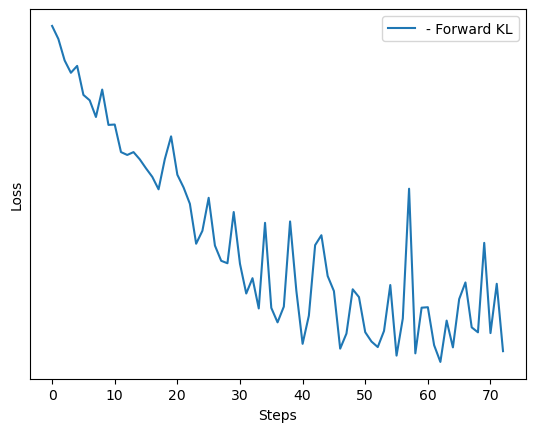

<Figure size 640x480 with 0 Axes>

In [5]:
run_inference(theta_train, x_train, config=config,
              plot_loss=True, load_state=False)

### Load testing data

In [6]:
theta_test = pd.read_csv('simulations_SM_test_1000__f_Da_ODI_u0_u1.csv', header=None).values
x_test = pd.read_csv(f'simulations_SM_test_1000__S_snr_50.csv', header=None).values
theta_test, x_test = preprocess_data(theta_test, x_test, bvals)

### Estimate the posterior distributions of an example signal
Plot the obtained distributions and the ground truth parameters that were used to generate the signal.

In [10]:
# Without postprocessing
_ = estimate_microstructure(x_test[1,:], config, plot=True,
                            theta_gt=theta_test[1,:])

Parameters: ['f', 'Da', 'ODI', 'u0', 'u1']
Ground truth theta = [0.70027 0.43056 0.6132  0.47791 0.48476]
Estimated theta = [0.7717718  0.518018   0.58163166 0.4984985  0.45245245]
Degeneracies = [False False False False False]
Uncertainties = [13.86021823 11.09349317 22.31907909 29.0928103  25.85704848] %
Ambiguities = [25.5 19.8 39.6 52.1 37.6] %


In [8]:
# With postprocessing
# Convert u0 and u1 to De_par and De_perp and plot results
_ = estimate_microstructure(x_test[1,:], config, postprocessing=postprocess_SM,
                            plot=True)

Parameters: ['f', 'Da', 'ODI', 'De_par', 'De_perp']
Estimated theta = [0.7727728 0.5122122 0.5880781 2.2336335 1.0318319]
Degeneracies = [False False False False False]
Uncertainties = [14.02063966 11.34559718 22.04645668 20.54109861 16.67058571] %
Ambiguities = [25.9 20.1 39.2 34.5 22.4] %
